In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time


In [ ]:
path_to_download = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

path_to_file = os.path.join(os.path.dirname(path_to_download), 'spa-eng', 'spa.txt')

2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def preprocess_sentences(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a bout." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except alphabet, ., ?, !, ,
    w = re.sub(r"[^a-zA-Z?.!,¿]+", ' ', w)

    w = w.strip()

    # adding end and start token to sentence to know when to start and stop predict
    w = '<start> %s <end>' % w
    return w



In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(preprocess_sentences(en_sentence))
print(preprocess_sentences(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
def create_dataset(path, num_examples):
    """
    Remove the accents
    Clean the sentences
    Return word pairs in the format: [en, sp]
    :param path:
    :param num_examples:
    :return:
    """
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentences(word) for word in line.split('\t')] for line in lines[:num_examples]]
    return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    """
    Creating cleaned input, output pairs
    :param path:
    :param num_examples:
    :return: input, target tensor and tokenize
    """
    target_lang, input_lang = create_dataset(path, num_examples)
    input_tensor, input_lang_tokenizer = tokenize(input_lang)
    target_tensor, target_lang_tokenizer = tokenize(target_lang)

    return input_tensor, target_tensor, input_lang_tokenizer, target_lang_tokenizer

In [ ]:
# Fast Vs Good
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_len_target, max_len_input = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Train and validation set
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,
                                                                                                target_tensor,
                                                                                                test_size=.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [ ]:
# Encoder and Decoder
# The input is put through an encoder model which give the encoder output of shape
# (batch_size, max_length, hidden_size) and the encoder hidden state of shape (batch_size, hidden_size)
# a_ts = exp(score(ht,hs)) /  sum(exp(score(ht,hs)) Attention weights
# ct = sum(a_ts * hs)               Context vector
# at = f(ct, ht) = tanh(Wc[ct;ht])  Attention vector
# score(ht, hs) = ht.T*W*h_s or v_a.T * tanh(W1*ht + W2*h2))

# score = FC(tanh(FC(EO) + FC(H))) (EO: encoder output)
# attention weights = softmax(score, axis=1) (axis 1 is max_length of input)
# context vector = sum(attention weights * EO, axis=1)
# embedding_output = the input to the decoder X is passed through an embedding layer
# merged vector = concat(embedding output, context vector)
# then feed to GRU

class Encoder(tf.keras.Model):
    def get_config(self):
        pass

    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden=None, *args):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))


encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values=None, *args, **kwargs):
        """
        query hidden state shape == (batch_size, hidden size)
        query_with_times_axis shape == (batch_size, 1, hidden_size)
        # values shape = (batch_size, max_len, hidden_size)
        broadcast addition along the time axis to calculate the score
        :param query:
        :param values:
        :param args:
        :param kwargs:
        :return:
        """
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape = (batch_size, max_length, 1)
        # get a at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, decode_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decode_units = decode_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.decode_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.decode_units)

    def call(self, x, hidden=None, enc_output=None, *args, **kwargs):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation = (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, shape=(-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights


decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_func(target, predict):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, predict)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './machine_translate_seq2seq_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [ ]:
# Training
# Pass the input through the encoder which return encoder output and the encoder hidden state
# The encoder output, encoder hidden state and the decoder input is passed to the decoder
# The decoder return the predictions and the decoder hidden state
# The decoder hidden state is then passed back into the model and the predictions
# are used to calculate the loss
# Use target word passed as the next input to the decoder to decide the next input to the decoder
# Then calculate the gradients and apply into optimizer and backpropagate

@tf.function
def train_step(inp, target, enc_hidden):
    loss = 0

    with tf.GradientTape() as g:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, target.shape[1]):
            # Pass enc_output to decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_func(target[:, t], predictions)

            dec_input = tf.expand_dims(target[:, t], 1)

    batch_loss = (loss / int(target.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = g.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, target)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, target, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch %d Batch %d Loss %.4f' % (epoch + 1, batch, batch_loss.numpy()))


    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6266
Epoch 1 Batch 100 Loss 2.1336
Epoch 1 Batch 200 Loss 1.9243
Epoch 1 Batch 300 Loss 1.8248
Epoch 1 Loss 2.0274
Time taken for 1 epoch 44.048670291900635 sec

Epoch 2 Batch 0 Loss 1.4617
Epoch 2 Batch 100 Loss 1.5378
Epoch 2 Batch 200 Loss 1.3653
Epoch 2 Batch 300 Loss 1.2314
Epoch 2 Loss 1.3833
Time taken for 1 epoch 33.297605991363525 sec

Epoch 3 Batch 0 Loss 1.0757
Epoch 3 Batch 100 Loss 1.0249
Epoch 3 Batch 200 Loss 1.0006
Epoch 3 Batch 300 Loss 0.8782
Epoch 3 Loss 0.9453
Time taken for 1 epoch 32.94306707382202 sec

Epoch 4 Batch 0 Loss 0.7620
Epoch 4 Batch 100 Loss 0.6685
Epoch 4 Batch 200 Loss 0.5902
Epoch 4 Batch 300 Loss 0.5069
Epoch 4 Loss 0.6294
Time taken for 1 epoch 32.927040338516235 sec

Epoch 5 Batch 0 Loss 0.3975
Epoch 5 Batch 100 Loss 0.3829
Epoch 5 Batch 200 Loss 0.3912
Epoch 5 Batch 300 Loss 0.4713
Epoch 5 Loss 0.4269
Time taken for 1 epoch 33.457534313201904 sec

Epoch 6 Batch 0 Loss 0.2650
Epoch 6 Batch 100 Loss 0.3187
Epoch 6 Batch 200 

In [ ]:
# Translate
# The input to the decoder at each time step is its previous predictions along with the hidden state and
# the decoder output
# Stop prediction when reach end token and store the attention weights for every time step
# The encoder output is calculated only once for one input

def evaluate(sentence):
    attention_plot = np.zeros((max_len_target, max_len_input))

    sentence = preprocess_sentences(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_len_input, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_len_target):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # Storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, shape=(-1, ))
        attention_plot[t] = attention_weights.numpy()

        prediction_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[prediction_id] + ' '

        if targ_lang.index_word[prediction_id] == '<end>':
            return result, sentence, attention_plot

        # Feed back into the model the predicted id
        dec_input = tf.expand_dims([prediction_id], 0)

    return result, sentence, attention_plot

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    ax.set_xticklabels([''] + sentence, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % sentence)
    print("Predicted translation: {}".format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


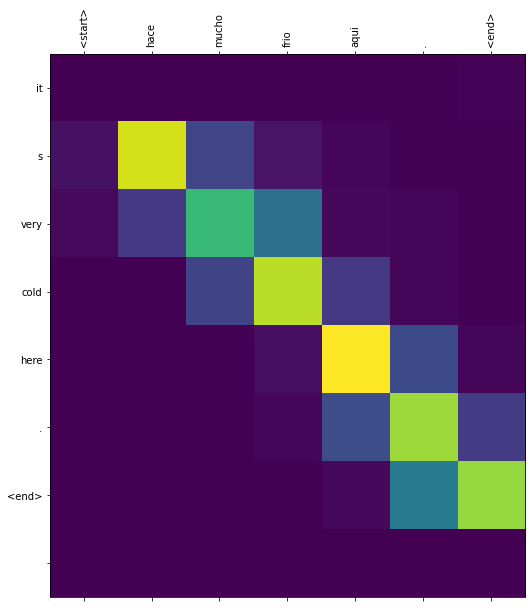

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

translate(u'hace mucho frio aqui.')